# A Fourier-Based Matrix Decomposition Scheme for Poisson's Equation on the Unit Disc 

In [1]:
import numpy as np

from numpy.fft import fft, ifft
from scipy import sparse
import scipy.sparse.linalg

import matplotlib.pyplot as plt

import cmocean
import cmocean.cm as cmo

import time

# this makes sure the images don't come out looking muddy on 
# retina displays (which your computer probably uses)
%config InlineBackend.figure_format='retina'

# References 

- Bialecki and Wright, "A fast direct solver for a fourth order finite difference scheme for Poisson’s equation on the unit disc in polar coordinates", Num. Algor., vol. 70, pp. 727–751, 2015. https://doi.org/10.1007/s11075-015-9971-z




- Samarskii and Nikolaev, "Numerical Methods for Grid Equations", vol. 1, Birkhäuser, 1989 




- Wendland, *Numerical Linear Algebra: An Introduction*, Cambridge Univ. Press, 2017

## Theory

### Setup

Let $D\subseteq \mathbb{R}^2$ denote the open unit disc centred about the origin. We are interested in solving the Dirichlet problem for Poisson's equation: 
\begin{equation}
\left\{
\begin{aligned}
\Delta u(r,\theta) &= f(r,\theta) \quad \forall \  (r,\theta)\in D
\\ \\ 
u|_{\partial D} &= g(\theta). 
\end{aligned}
\right. 
\end{equation}

The numerical schemes for solving this boundary-value problem are as grains of sand on a beach: we could use a finite-difference discretization of $\Delta$, mix together a Fourier spectral discretization in $\theta$ with a Chebyshev spectral discretization in $r$, move the problem to a boundary integral equation and solve that with FMM, use a vanilla or mixed FEM, use a probabilistic method based on Brownian motion, teach a neural network to learn Laplacian inversion... or something else entirely! 

In this demo, we discuss a "hybrid" scheme that uses finite differences to obtain a discrete Laplacian $\Delta_{h}$, then efficiently inverts $\Delta_{h}$ by moving to Fourier space. The aforementioned efficiency comes from breaking down the inversion of $\Delta_{h}$ into a large but finite number of smaller **tridiagonal** matrix inversions, each of which can be rapidly accomplished with a sparse direct solver. In geometric terms, the reduction I have just described roughly amounts to solving our Poisson equation ray-by-ray. 

Bialecki and Wright refer to this scheme as a *matrix decomposition method*, but in Samarskii and Nikolaev, this type of scheme is called a *cyclic reduction method*. Since using fashionable appellations is always a wise choice, we'll keep with Bialecki and Wright's terminology, but I emphasize now that Bialecki and Wright are not the originators of the method we shall discuss here (in their own paper, they say that similar schemes were known in Soviet literature since at least 1976). Since Bialecki and Wright's discussion is very clear, I won't bother re-writing all of the required formulas and filling in every detail. 

### Description of Finite Difference Discretization

We use $M+1$ grid points to mesh $r\in [0,1]$ and $N+1$ grid points to mesh $\theta\in [0,2\pi]$. The grid spacing in $r$ is 
$$
h_r = \frac{1}{M+\frac12}
$$
and the grid spacing in $\theta$ is
$$
h_{\theta} = \frac{2\pi}{N}. 
$$
So, the $k^{\text{th}}$ angular grid point is $\theta_{k} = kh_{\theta}$. For the radial part of the grid, we avoid touching $r=0$ directly (this is because the polar coordinate Laplacian is riddled with divisions by $r$) by starting our grid a "half-point shift" away from the origin. That is, our radial mesh is really a mesh of $\left[\frac12 h_r, 1\right]$. The $j^{\text{th}}$ radial grid point is then 
$$
r_{j} = \left(j+\frac12\right) h_r, \quad j=0,1,...,M. 
$$
Next, recall that the polar-coordinate form of Poisson's equation can be written more explicitly as 
$$ 
\partial_{r}\left(ru_{r}\right) + \frac{1}{r} \partial_{\theta}^2u = rf. 
$$
We use the standard centred second-order finite difference approximation to discretize $\partial_{\theta}^2$. For the radial derivatives, we use second-order centred ("spatial leapfrog") approximations. According to Bialecki and Wright, one can show the discretization is also stable, hence the scheme is convergent of order $2$ with respect to both variables (assuming regular boundary data and forcing). 

Such a finite difference discretization gives rise to an $MN \times MN$ sparse linear system. If we define the restriction of our solution samples $u_{jk}$ to the $j^{\text{th}}$ circle by $\mathbf{U}_{j}$, then this system has the following form: for $j=0,...,M-1$, solve 

$$
\mu_{j}\mathbf{U}_{j-1} + \left(\gamma_{j}P+\delta_{j}\right)\mathbf{U}_{j} + \nu_{j}\mathbf{U}_{j+1} = \mathbf{F}_{j}
$$

where $\mu_{j}, \gamma_{j}, \delta_{j}, \nu_{j}$ are functions of the grid parameters $M, N$, $P$ is the almost-tridiagonal $N\times N$ matrix

$$
P = \begin{pmatrix}
-2 & 1 & 0 \cdots & 0 & 1
\\
1 & -2 & 1 & 0 \cdots 
\\
& & \ddots 
\\
1 & 0 \cdots & 1 & -2
\end{pmatrix}
$$

(think of $P$ as the Laplacian on the $N^{\text{th}}$ roots of unity $\mathbb{Z}_{N}$), and $\mathbf{F}_{j}$ represents the effect of the forcing along the $j^{\text{th}}$ circle: if $j=M-1$, this term also incorporates information on the BCs. 

Critically, these systems are not decoupled! $\mathbf{U}_{j}$ mixes with $\mathbf{U}_{j\pm 1}$. In other words, each circle depends "tridiagonally" on itself and the two circles nearest to it. Is there a way to somehow transform the equations so that they do decouple? The answer is pretty much "yes", provided we switch from working *circle-wise* to working *ray-wise* after transforming. 

Since the $\mathbf{U}_{j}$'s are all restricted to a single (meshed) circle, there is an obvious simplifying transformation that jumps out at us: the discrete Fourier transform, which can be executed quickly via the FFT. The FT diagonalizes the "discrete Laplacian" $P$, so that if we denote FT by a hat then our equations become

$$
\mu_{j}\widehat{\mathbf{U}}_{j-1} + \left(\gamma_{j}\Lambda+\delta_{j}\right)\widehat{\mathbf{U}}_{j} + \nu_{j}\widehat{\mathbf{U}}_{j+1} = \widehat{\mathbf{F}}_{j}.
$$

with $\Lambda\in \mathbb{R}^{N\times N}$ diagonal. Thus, every $\widehat{\mathbf{U}}_{\text{whatever}}$ is hit by a diagonal matrix. This is a simplification, but not quite a decoupling: while the linear system to be solved along each circle is diagonal, the systems altogether remain coupled. 

Here comes the really clever part. Treat each $\widehat{\mathbf{U}}_{j}$ like a row vector, and stack them up all in an array 
$$
\widehat{U} = 
\begin{pmatrix} 
\widehat{U}_{0}
\\
\cdots
\\
\widehat{U}_{M-1}
\end{pmatrix} \in \mathbb{R}^{M\times N}. 
$$
This is equivalent to thinking that we have stored the solution $u$ as an $M\times N$ array and have then Fourier transformed this array row-wise. Then, let $\mathbf{v}_{k}$ denote the $k^{\text{th}}$ colum of $\widehat{U}$: 
$$
\mathbf{v}_{k} = \left[ \left(\widehat{U}_{0}\right)_{k}, ..., \left(\widehat{U}_{M-1}\right)_{k}\right]^{\text{T}} \in \mathbb{R}^{M}. 
$$
$\mathbf{v}_{k}$ is then the restriction of the Fourier-transformed solution to the ray inclined at angle $\theta_{k}$.

What linear equation does each $\mathbf{v}_{k}$ satisfy? In other words, what does our Fourier-transformed system look like *ray-wise*? Since we've Fourier-transformed, all rays must be independent. So, the ray equations are all decoupled. Further, a bit of thought shows that if 

$$ 
R_{k} = \begin{pmatrix}
d_{1}(k) & \nu_{1} & 0 & \cdots
\\
\mu_{1} & d_2(k) & \nu_{2} & 0 &\cdots
\\ 
& & \ddots
\\
0 & \cdots & 0 & \mu_{M-2} & d_{M-1}(k)  & \nu_{M-1}
\\
0 & \cdots & 0 & 0 & \mu_{M-1} & d_{M}(k) 
\end{pmatrix} \in \mathbb{R}^{M\times M},
$$

where $d_{j}(k) =\gamma_{j}\Lambda_{kk} +\delta_{j}$, then 

$$
R_{k}\mathbf{v}_{k} = \boldsymbol{\mathcal{F}}_{k}
$$

where $\boldsymbol{\mathcal{F}}_{k}$ is relatively easy to compute. So, finding each $\mathbf{v}_{k}$ involves solving a tridiagonal $M\times M$ system. This type of system is very easy to solve directly by Gaussian elimination/LU factorization. In fact, it turns out that $R_{k}$ is also diagonally dominant, so such a direct solves only takes $\mathcal{O}\left(M\right)$ time (see Wendland pp. 70-71). Finding every $\mathbf{v}_{k}$, and therefore finding $\widehat{\mathbf{U}}$, will then take only $\mathcal{O}\left(MN\right)$ time. 

From here, to recover $u$ we simply apply the inverse FFT to each row of $\widehat{\mathbf{U}}$, which will take a total of 
$$
\mathcal{O}(M)\times \mathcal{O}\left(N\log N\right) = \mathcal{O}\left(MN\log N\right)
$$
operations. It takes a similar amount of time to perform the forward FFTs required to assemble each linear system $R_{k}\mathbf{v}_{k} = \boldsymbol{\mathcal{F}}_{k}$. Therefore, this Fourier-based pipeline for solving our discretized Poisson equation has a total cost of only
$$
\mathcal{O}\left(MN\log N\right)!
$$
It would be a gross understatement to call this an "improvement" over the naive solve time $\mathcal{O}\left((MN)^3\right)$! This cost *just barely fails to be optimal with the presence of the log*. So, our matrix decomposition method is nothing to scoff at! 

We summarize our discussion of the wonderful blessing of decoupled ray-wise equations with the following fast algorithm for solving the Dirichlet BVP for Poisson's equation: 


1) Assemble the right-hand sides $\boldsymbol{\mathcal{F}_{k}}, k=0,1,...,N-1$ with the FFT. 


2) Assemble the matrices $R_{k}\in \mathbb{R}^{M\times M} , k=0,1,...,N-1.$  


3) Use a direct method to solve all the tridiagonal systems
$$
R_{k}\mathbf{v}_{k} = \boldsymbol{\mathcal{F}_{k}}
$$
and store each $\mathbf{v}_{k}$. 

4) Collect all the column vectors $\mathbf{v}_{k}$'s into a single array 
$$
\widehat{U} = 
\begin{pmatrix} 
\mathbf{v}_{0}  | \cdots |\mathbf{v}_{N-1} 
\end{pmatrix} \in \mathbb{R}^{M\times N}
$$
and set our approximate solution $u$ to be the row-wise IFFT of $\widehat{U}$. 


This algorithm is convergent of order $2$ in both spatial variables, and runs in $\mathcal{O}\left(MN\log N\right)$ time. 

## Implementation 

Now, we try out this matrix decomposition algorithm in Python using the simple test case 
$$
f = e^r(r+3)\cos\theta, \quad g(\theta) = e\cos(\theta). 
$$
This problem admits the exact solution 
$$
u_{\text{exact}} = re^r\cos\theta,
$$
so determining the errors in our approximation will be straightforward. 

Using our solver, we shall confirm the theoretical order $2$ convergence rate. Additionally, we'll establish that the cost estimate of $\mathcal{O}\left(MN\log N\right)$ is a worst-case scenario: at least for our simple problem, the solve time is much less than this estimate predicts. 

In [2]:
# solve the Poisson equation given the forcing term sampled on grid , BCs sampled on grid,
# and grid parameters
def solve_poisson(f, g, M, N):
    
    # pick up grid sizes 
    dr = 1./(0.5+M)
    
    dtheta = 2.*np.pi/N
    
    # first assemble forcing (which is inputted as an (M+1) x N array)
    
    # forcing must be multiplied by r. 
    # This can be done without a loop thanks to a nice trick here:
    # https://stackoverflow.com/questions/18522216/multiplying-across-in-a-numpy-array
    r = (np.arange(0, M+1)+0.5)*dr 
    f = f * r[:, np.newaxis] 
    
    # now subtract influence of bdry data
    f[M-1,:] -= M*g/dr 
    
    # take fft of new forcing term 
    fhat = fft(f, axis = 1)
        
    # now figure out the linear system to be solved
    
    # define the vectors that will appear in constructing the diags
    
    intrvl = np.arange(1,M+1)
    
    mu = intrvl[:-1]/dr # with our indexing conventions this is the same as nu in BW2015
    
    gamma = (2./(dr*dtheta**2))/(2.*intrvl -1.) 
            
    delta = (1.-2.*intrvl)/dr
    
    # initialize the data storage arrays
    v_store = (1+0j)*np.zeros([M, N], dtype=float)
    
    u = np.zeros([M+1, N], dtype=float)
    
    u[M, :] = np.reshape(g, [N]) # add the boundary data
    
    # loop thru each reduced tridiagonal system, solve it, and store the result
    for n in np.arange(0,N):
        
        # assemble right-hand side of linear system 
        rhs = fhat[0:M, n]
        
        # create diagonal using analytical expression for Lambda (see Samarskii & Nikolaev)
        freq = -(2.*np.sin(n*np.pi/N))**2    
        # TODO: what would happen if we used a "naive" value for the frequencies, ie. following
        # from the continuous FT case instead? 
        R0 = gamma*freq + delta 
        
        # create the sparse matrix 
        R = sparse.diags([R0, mu, mu], [0, 1, -1], shape=(M,M))
        # TODO: is there a way to avoid redefining off-diags every time without addition 
        # or subtraction? 
                
        # change matrix format to avoid an efficiency warning
        R = R.tocsc()
        
        # now do a direct solve  
        v = sparse.linalg.spsolve(R, rhs)
        
        # store the result of the solve
        v_store[:, n] = np.reshape(v, [M])
        
    # perform row-wise Fourier transform and thereby recover the solution 
    u[0:M, :] = np.real(ifft(v_store, axis = 1)) 
    
    # tack on theta = 2pi chunk to enforce periodicity 
    u = np.c_[u, u[:,0]]
    
    return u

In [3]:
# define the forcing term for our Poisson equation 
def forcing(r, theta, M, N):
    
    theta_plt = np.append(theta, 2*np.pi)
    rr, tt = np.meshgrid(r, theta_plt)
    out = np.exp(rr)*(rr+3.)*np.cos(tt)
    out = out.T[:, :-1]
    
    return out 

In [4]:
# define the Dirichlet boundary condition 
def BC(theta, N): 
    
    out = np.exp(1)*np.cos(theta)
    
    return out 

With the solver, forcing, and BCs defined, we can start to define our particular problem. 

In [5]:
M = 2**9
N = 2**9

dtheta = 2.*np.pi/N

dr = (0.5+M)**-1

theta = np.linspace(0., 2.*np.pi, N, endpoint=False)

r = (np.arange(0, M+1)+0.5)*dr # use the half-point shift to avoid meshing 0. 
# Note that the last entry of $r$ is r=1, so when plotting we must be careful 
# to include the bdry values of our scalar field. 

We now run and time our solver: 

In [6]:
start=time.time()
f = forcing(r,theta, M, N)
g = BC(theta, N)
u = solve_poisson(f, g, M, N)
end=time.time()
runtime=end-start
print('Total runtime of solve = %.4f seconds' % runtime)

Total runtime of solve = 0.5375 seconds


With $M=N=2^9$, I found the assembly and solve took about half a second! Let's look at the approximate solution and compute its error against the exact solution. 

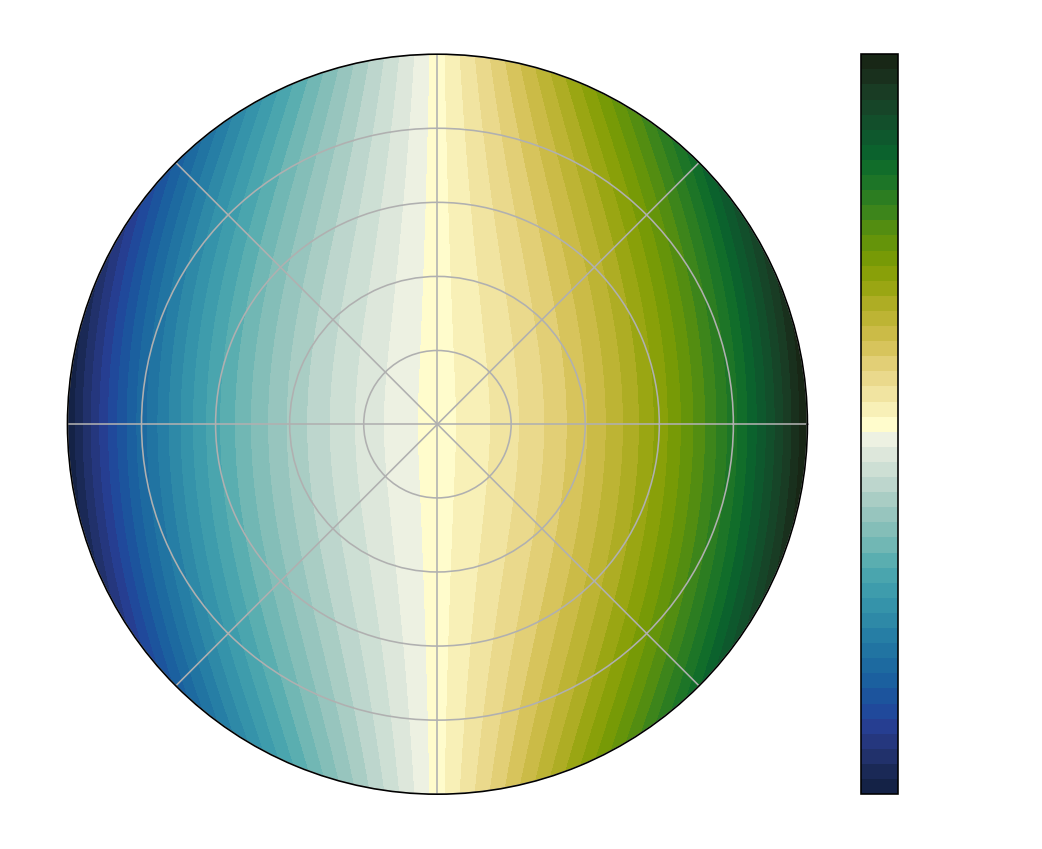

In [7]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))

theta_plt = np.append(theta, 2*np.pi)
u_approx = u
rr, tt = np.meshgrid(r, theta_plt)
u_plt = u_approx.T # must transpose bcz of meshgrid conventions

umax = np.amax(u_plt)
umin = np.amin(u_plt)

CF = ax.contourf(tt, rr, u_plt, cmap=cmo.delta, levels=np.linspace(umin,umax,50))

textcolor = 'w'

# axis labels
#"""
plt.tick_params(axis='x', which='both', top='off', color = textcolor)
plt.xticks(fontsize=14, rotation=0, color = textcolor)
ax.set_yticklabels([])
#plt.tick_params(axis='y', which='both', right='off', color = textcolor)
#plt.yticks(fontsize=12, rotation=0, color = textcolor)
#"""

cbar = plt.colorbar(CF,  format='%.3f')
cbar.ax.tick_params(labelsize=14, color=textcolor) 
cbar.ax.set_ylabel(r'$u(r,\theta)$', fontsize=18, color=textcolor)
cbytick_obj = plt.getp(cbar.ax.axes, 'yticklabels')                
plt.setp(cbytick_obj, color='w')

fig.set_size_inches(8,6)

plt.tight_layout()

"""
fignamepng = 'laplace_disc_test_N=%i' % N +'.png'
plt.savefig(fignamepng, dpi=400)
"""

plt.show()

In [8]:
u_exact = rr*np.exp(rr)*np.cos(tt)
error = np.amax(np.abs(u_exact-u_approx.T))
print('L^infty error = %.7f' % error)

L^infty error = 0.0000045


So, when $M=N=2^9$ we get 5 decimal places of accuracy in half a second! This is pretty nice. 

Now, let's perform a detailed accuracy study. We know the exact solution for our test case, so we can compute approximation errors easily. Additionally, we'll also collect information on runtime for each solve. For simplicity, we take $M=N$ for all our tests. 

In [9]:
Ms = np.logspace(4, 11, num=7, base=2.).astype(int)
num_Ms = np.size(Ms)

errors = np.zeros([num_Ms], dtype=float)
runtimes = np.zeros([num_Ms], dtype=float)

for m in np.arange(0, num_Ms):
    
    M = Ms[m]
    
    N = M
    
    dtheta = 2.*np.pi/N

    dr = (0.5+M)**-1

    theta = np.linspace(0., 2.*np.pi, N, endpoint=False)

    r = (np.arange(0, M+1)+0.5)*dr
    
    start=time.time()
    f = forcing(r,theta, M, N)
    g = BC(theta, N)
    u_approx = solve_poisson(f, g, M, N)
    end=time.time()
    runtime=end-start
    
    runtimes[m] = runtime
    
    theta_plt = np.append(theta, 2*np.pi)
    rr, tt = np.meshgrid(r, theta_plt)
    u_exact = rr*np.exp(rr)*np.cos(tt)
    error = np.amax(np.abs(u_exact-u_approx.T))
    
    errors[m] = error    

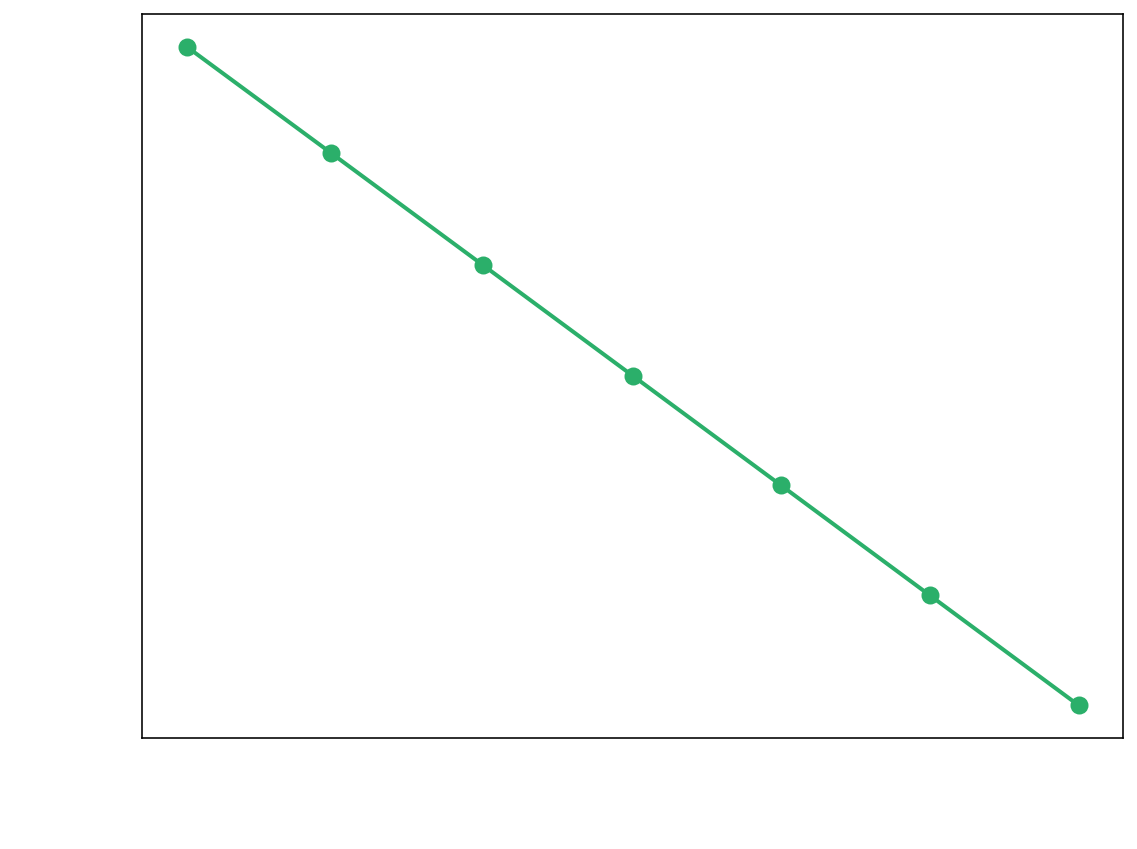

In [10]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, ax = plt.subplots()

textcolor='w'

plt.loglog(Ms, errors, 'o', color='xkcd:jade green', markersize='8')
plt.loglog(Ms, errors,  color='xkcd:jade green', linewidth='2', linestyle='solid')

plt.xlabel(r"$N$", fontsize=26, color=textcolor)
plt.ylabel(r"$L^{\infty}$ Error", fontsize=26, color=textcolor)

plt.tick_params(axis='x', which='both', top=False, color=textcolor)
plt.xticks(fontsize=16, rotation=0, color=textcolor)
plt.tick_params(axis='y', which='both', right=False, color=textcolor)
plt.yticks(fontsize=16, rotation=0, color=textcolor)

fig.set_size_inches(8,6)

plt.tight_layout()

#plt.savefig('accuracy_test', bbox_inches='tight', dpi=800)

plt.show()


In [11]:
params = np.polyfit(np.log10(Ms), np.log10(errors), 1)
slope = params[0]

print('Estimated slope of error curve = ', slope)

Estimated slope of error curve =  -1.9981714088723506


Thus we have empirically confirmed the second-order accuracy of the scheme. 

To conclude, let's look at how the solve time depends on $M=N$. 

Estimated slope of runtime best-fit line =  1.207670852726626


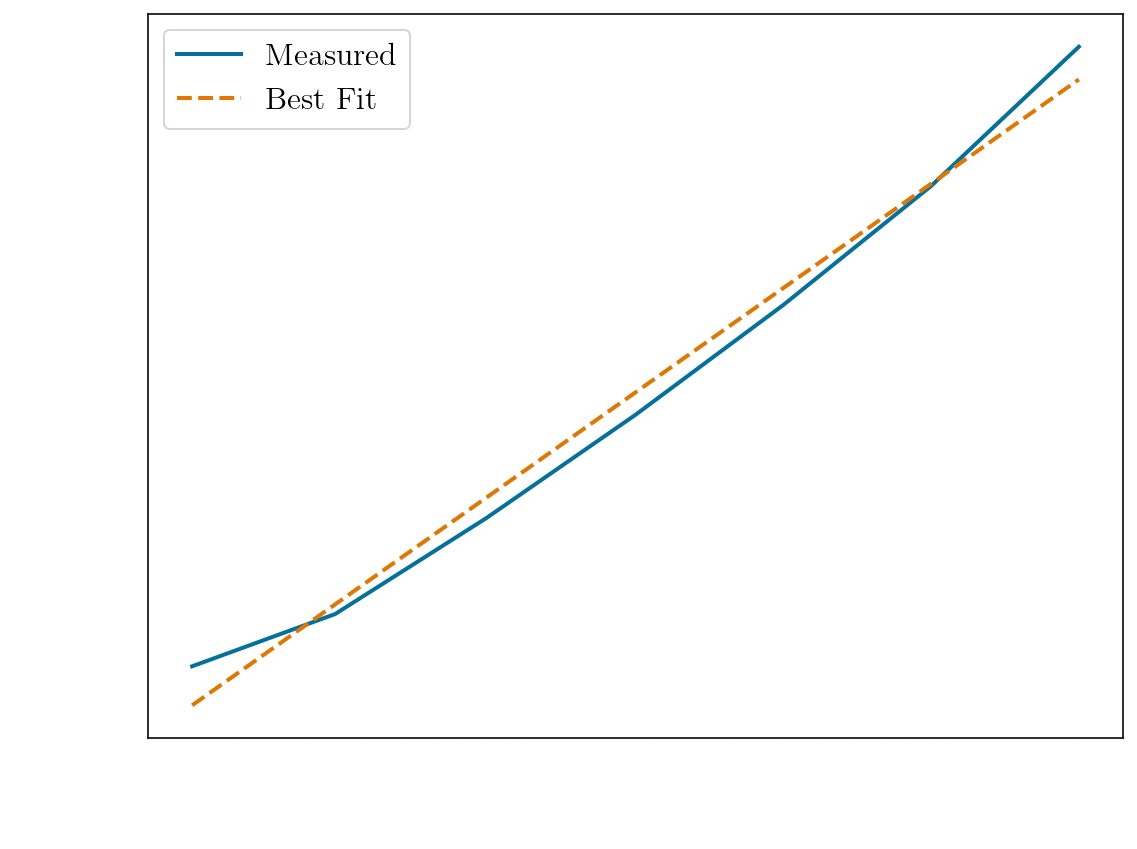

In [12]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, ax = plt.subplots()

textcolor='w'

plt.loglog(Ms, runtimes,  color='xkcd:ocean blue', linewidth='2', linestyle='solid', label='Measured')

params = np.polyfit(np.log10(Ms), np.log10(runtimes), 1)
slope = params[0]
intercept = params[1]

print('Estimated slope of runtime best-fit line = ', slope)

plt.loglog(Ms, (Ms**slope)*(10**intercept),  color='xkcd:pumpkin', linewidth='2', linestyle='dashed', label='Best Fit')

plt.xlabel(r"$N$", fontsize=26, color=textcolor)
plt.ylabel(r"Solve Time (s)", fontsize=26, color=textcolor)

plt.tick_params(axis='x', which='both', top=False, color=textcolor)
plt.xticks(fontsize=16, rotation=0, color=textcolor)
plt.tick_params(axis='y', which='both', right=False, color=textcolor)
plt.yticks(fontsize=16, rotation=0, color=textcolor)

ax.legend(fontsize=16)

fig.set_size_inches(8,6)

plt.tight_layout()

#plt.savefig('speed_test', bbox_inches='tight', dpi=800)

plt.show()


This plot shows that the large-$N$ behaviour of the runtime is roughly $\mathcal{O}\left(N^{1.2}\right)$, which is even better than the theoretical prediction of $\mathcal{O}\left(N^{2}\log N\right)$. So, the theoretical runtime really is a "worst-case scenario", and in practice we may find the solve is quite a bit faster. 

TODO:
- Fix FFT stuff so it is as efficient and quick as possible! Don't want to be keeping around a bunch of complex numbers we don't need 
- Add an option for different test cases? 
- Comparison w/ other methods (naive fd in Strikwerda, Chebyshev pseudospectral, multigrid, BIE)?